In [1]:
%matplotlib inline
import sys
sys.path.append('../src')

import requests

import uschartbook.config

from uschartbook.config import *
from uschartbook.utils import *

In [2]:
unemp = lambda x: np.where(x['LFS'] == 'Unemployed', 1, 0)
emp = lambda x: np.where(x['LFS'] == 'Employed', 1, 0)

def weighted_average(df, variable):
    return np.average(df[variable], weights=df['BASICWGT'])

In [10]:
cols = ['YEAR', 'MONTH', 'LFS', 'AGE', 'BASICWGT', 'FEMALE', 'NCHILDU5']

df = (pd.concat([pd.read_feather(cps_dir / f'cps{year}.ft', columns=cols)
                 .query('AGE > 15').assign(UNEMP=unemp, EMP=emp) 
                 for year in range(1989, 2020)], sort=False))

In [4]:
peak_years = [1997, 1998, 1999, 2000]
emp_by_age = (df.query('YEAR in @peak_years').groupby('AGE')
                .apply(weighted_average, 'EMP').loc[15:].to_dict())

In [5]:
emppr = lambda x: x['AGE'].map(emp_by_age)

df = df.assign(EMPPR = emppr)

data = pd.DataFrame(df.groupby(['YEAR', 'MONTH']).apply(weighted_average, 'EMPPR').rename('EMP_PR'))

date_index = pd.to_datetime(data.index.map('{0[0]}-{0[1]}-01'.format))
data.index = date_index

data.plot()

In [6]:
emp_act = df.groupby(['YEAR', 'MONTH']).apply(weighted_average, 'EMP')
emp_act.index = date_index
data['EMP_ACT'] = emp_act

unemp_act = df.groupby(['YEAR', 'MONTH']).apply(weighted_average, 'UNEMP')
unemp_act.index = date_index
data['UNEMP_ACT'] = unemp_act

data['DIFF'] = data['EMP_PR'] - data['EMP_ACT']

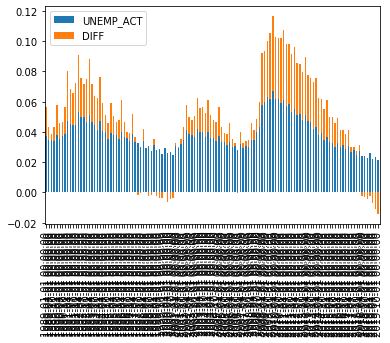

In [7]:
data[['UNEMP_ACT', 'DIFF']].resample('QS').mean().plot(kind='bar', stacked=True)

In [16]:
moms = (df.query('FEMALE == 1 and NCHILDU5 > 0 and 21 <= AGE <= 50')
          .groupby(['YEAR', 'MONTH']).apply(weighted_average, 'EMP'))

In [17]:
moms.index = date_index

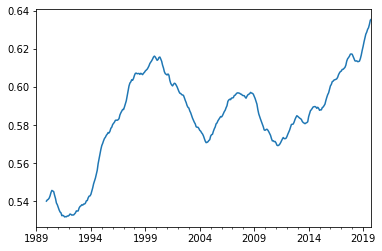

In [22]:
moms.rolling(12).mean().plot()